<a href="https://colab.research.google.com/github/yooburi/ML_DL_yooburi/blob/main/midterm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기계인공지능응용 Practice Page

## 분류(Classification) 개념

- **목표**: 주어진 입력을 여러 **범주(class)** 중 하나로 할당
- 예: 이메일 → 스팸/정상, 이미지 → 고양이/개, 환자 데이터 → 질병 여부
- **회귀 vs 분류**
    - 회귀: 연속 값 예측 (예: 집값)
    - 분류: 이산 클래스 예측 (예: 강아지/고양이)
- 출력층 활성화 함수
    - 다중 클래스: Softmax → 각 클래스 확률
    - 이진 분류: Sigmoid → 양성 클래스 확률

---

##이진 분류(Binary Classification)

이진 분류를 위해서는 출력층에 0~1을 만족하는 함수가 필요하며, sigmoid 함수를 이용해 이를 구현한다.

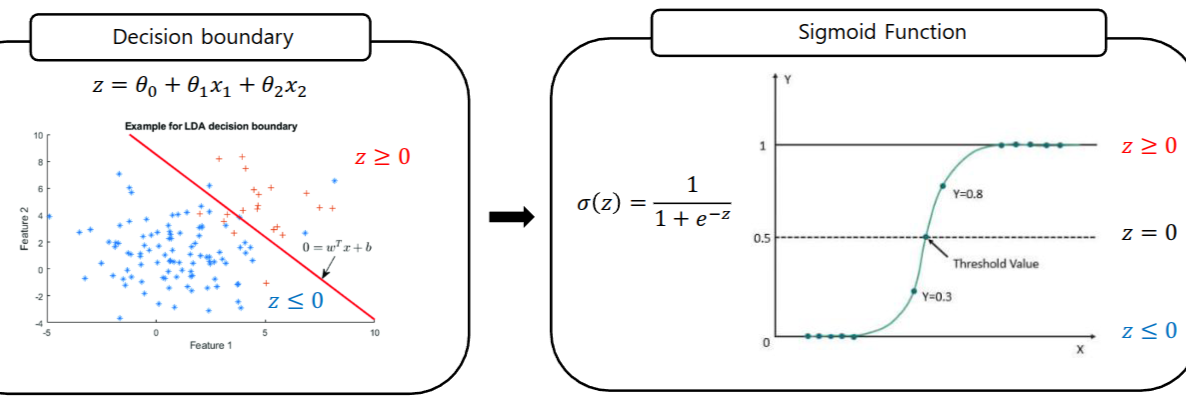

z는 입력변수와 가중치의 선형결합으로 결정 경계(Decision boundary)를 결정하는 역할을 한다.

이 경계를 기준으로 sigmoid 함수에 입력해 0~1 사이의 값으로 분류하게 된다.

---

### 데이터 준비: make_moons
- 2D 데이터로 시각화와 결정 경계(decision boundary) 관찰
- 학습/테스트 데이터 분리



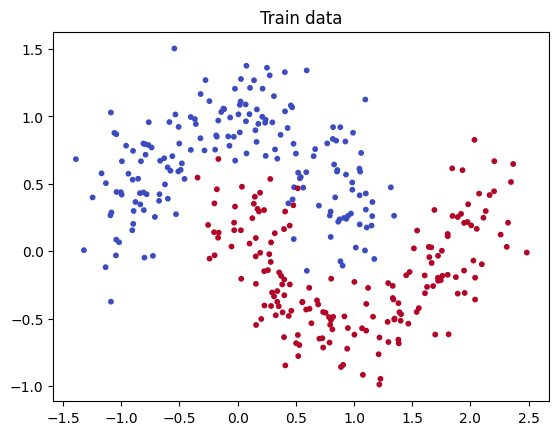

In [7]:
import torch
from sklearn.datasets import make_moons #데이터셋
from sklearn.model_selection import train_test_split #
import matplotlib.pyplot as plt

# make moon 함수를 이용해 반달 모양의 500개의 좌표 데이터 생성
# 반달 형태의 이진분류 데이터 500개 생성.(노이즈로 난이도 약각 up, 시드 고정으로 재현성)
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

# 학습 70% , 테스트 30%로 분리 + 재현성 고정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 시각화
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', s=10)
plt.title('Train data')
plt.show()

# 텐서 변환
# torch는 tensor 연산 지원.
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long) # 정수형
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long) # 정수형


> 왜 텐서로 변환할까??

```
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)
```
> pytorch 모델은 numpy 배열이 아니라 torch.Tensor를 입력으로 받아서 계산한다. torch.Tensor는 GPU에서 연산 가능한 데이터 구조. 자동 미분 기능을 지원하고 cuda GPU 연산을 지원한다. 즉, 딥러닝 연산을 위해 최적화된 데이터 형태.

> nn.Linear, nn.ReLU, nn.CrossEntropyLoss 같은 PyTorch 모듈은 모두 입력으로 Tensor 타입만 처리함.

###인공지능 모델 설정 Multi Layer Perceptron

- 은닉층: 2개, ReLU 활성화 함수 사용
- 출력층: 클래스 수만큼 노드, sigmoid 활성화 함수  사용

In [8]:
import torch.nn as nn

# nn.Module 상속한 다층퍼셉트론 클래스
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )

  # 순전파
  # 분류라면 마지막에 softmax 넣지 않는다 -> CrossEntropyLoss가 내부에서 처리
  def forward(self, x):
    return self.net(x)

model = MLP(2,16,2)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)


입력층(2) → 은닉층1(16) → 은닉층2(16) → 출력층(2)

가중치 파라미터의 개수
: 2×16+16×16+16×2+(16+16+2)=354

### 학습 준비
- 손실 함수: CrossEntropyLoss (softmax+NLLLoss)
- 옵티마이저: Adam
- 에폭 수, 배치 학습

> What is CrossEntropyLoss?


Epoch 20/100, Loss=0.0614
Epoch 40/100, Loss=0.0458
Epoch 60/100, Loss=0.0321
Epoch 80/100, Loss=0.0460
Epoch 100/100, Loss=0.0264


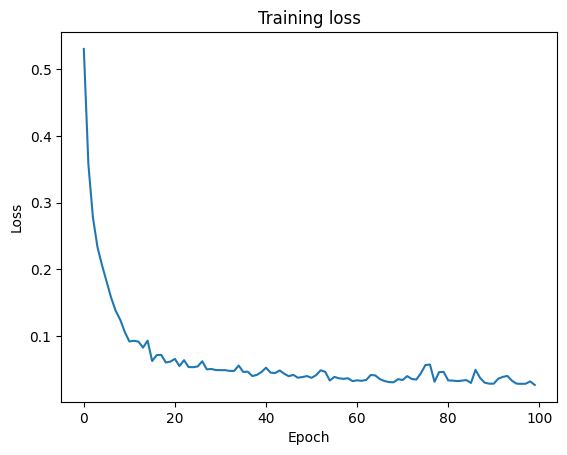

In [9]:
# 모델 출력 vs 정답으로 분류 손실 계산 -> 마지막에 softmax 필요 없음
criterion = nn.CrossEntropyLoss()
# 가중치 업데이트 규칙(adam), 학습률 지정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
batch_size = 32

# 데이터 로더 준비
# (입력, 라벨) 튜플로 묶음 -> 미니배치로 섞어서 공급
dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_hist = []
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad() #이전 step 기울기 초기화
        pred = model(xb) #순전파 -> predict value 출력
        loss = criterion(pred, yb) #배치 손실 계산
        loss.backward() #역전파 -> 기울기 계산
        optimizer.step() #가중치 업데이트
        total_loss += loss.item()*len(xb) #배치 손실을 샘플 수로 가중합해 에포크 평균 손실 준비

    loss_hist.append(total_loss/len(dataset)) #에포크 평균 손실 기록
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss={loss_hist[-1]:.4f}')

plt.figure()
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 평가 및 정확도 & 결정 경계 시각화

Test Accuracy: 98.00%


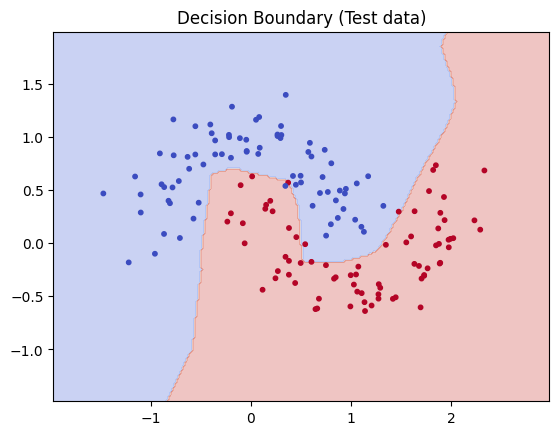

In [10]:
# 평가 및 정확도
with torch.no_grad(): #평가 시 기울기 계산 비활성화(메모리, 속도 이점)
    pred_test = model(X_test_t) #pred value by test dataset
    y_pred_cls = pred_test.argmax(dim=1)
    acc = (y_pred_cls == y_test_t).float().mean().item()
print(f'Test Accuracy: {acc*100:.2f}%')


#결정 경계 시각화
import numpy as np
h = 0.02
x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# 반복된 선형결합의 결과를 나타낸 값. -> 클래스 예측 맵
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid).argmax(dim=1).numpy()
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', s=10)
plt.title('Decision Boundary (Test data)')
plt.show()

## 다중 분류

### 3개의 분류값을 가지는 다중분류 -> 출력층에서 softmax 활용

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

